<a href="https://colab.research.google.com/github/Arpit-Baranwal/Machine-Learning-/blob/master/ecg_ppg_pat_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install numpy scipy matplotlib wfdb neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 7.7 MB/s eta 0:00:00


In [3]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [5]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath

import wfdb

In [24]:
import wfdb
import numpy as np

# Trying different segments - MIMIC often has 100+ segments per patient
patient_id = '3000393'
base_dir = 'mimic3wdb/1.0/30/3000393'

print(f"Searching for long segments for patient {patient_id}...")
print("This may take a minute...")

# Try segments 0001 to 0100
found_segments = []
for i in range(1, 101):
    segment = f"{patient_id}_{str(i).zfill(4)}"  # 0001, 0002, ..., 0100

    try:
        header = wfdb.rdheader(segment, pn_dir=base_dir)
        minutes = header.sig_len / (header.fs * 60)

        if minutes > 5:  # Look for segments >5 minutes
            print(f" Found: {segment} - {minutes:.1f} minutes")
            found_segments.append((segment, minutes))

            # check it has both ECG and PPG
            if 'II' in header.sig_name and 'PLETH' in header.sig_name:
                print(f"   Has both ECG (II) and PPG (PLETH)")
                record = wfdb.rdrecord(segment, pn_dir=base_dir)
                break

    except Exception as e:
        # Segment doesn't exist or other error
        pass

if found_segments:
    print(f"\nFound {len(found_segments)} long segments:")
    for seg, mins in sorted(found_segments, key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {seg}: {mins:.1f} minutes")
else:
    print("No long segments found for this patient. Try another patient.")

Searching for long segments for patient 3000393...
This may take a minute...
 Found: 3000393_0002 - 15.1 minutes
   Has both ECG (II) and PPG (PLETH)

Found 1 long segments:
  3000393_0002: 15.1 minutes


In [28]:
# Load the segment
record = wfdb.rdrecord(
    record_name='3000393_0002',
    pn_dir='mimic3wdb/1.0/30/3000393'
)

signals = record.p_signal
fs = record.fs
sig_names = record.sig_name

print(f" SUCCESS! Loaded: {record.record_name}")
print(f"Duration: {len(signals)/fs/60:.1f} minutes")
print(f"Sampling rate: {fs} Hz")
print(f"Available signals: {sig_names}")

# Extract ECG and PPG
ecg_idx = sig_names.index('II')  # Lead II ECG
ppg_idx = sig_names.index('PLETH')  # PPG

ecg = signals[:, ecg_idx]
ppg = signals[:, ppg_idx]

print(f"\nSignal Statistics:")
print(f"ECG (II): {len(ecg):,} samples, range: {ecg.min():.3f} to {ecg.max():.3f}")
print(f"PPG (PLETH): {len(ppg):,} samples, range: {ppg.min():.3f} to {ppg.max():.3f}")

print(f"\nECG has negative values: {(ecg < 0).any()}")
print(f"Number of negative ECG samples: {(ecg < 0).sum()}")

# Taking the first 5 minutes for faster processing
samples_5min = min(len(ecg), fs * 60 * 5)
ecg_5min = ecg[:samples_5min]
ppg_5min = ppg[:samples_5min]

print(f"\nUsing first 5 minutes: {samples_5min/fs/60:.1f} minutes")

 SUCCESS! Loaded: 3000393_0002
Duration: 15.1 minutes
Sampling rate: 125 Hz
Available signals: ['ABP', 'RESP', 'PLETH', 'II', 'V', 'AVR']

Signal Statistics:
ECG (II): 113,500 samples, range: nan to nan
PPG (PLETH): 113,500 samples, range: 0.000 to 4.002

ECG has negative values: True
Number of negative ECG samples: 7

Using first 5 minutes: 5.0 minutes


In [26]:
import neurokit2 as nk
import matplotlib.pyplot as plt

# Process ECG
print("\n1. Processing ECG...")
ecg_cleaned = nk.ecg_clean(ecg_5min, sampling_rate=fs)
ecg_peaks, _ = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)
r_peaks = ecg_peaks["ECG_R_Peaks"]
r_times = r_peaks / fs

print(f"   Found {len(r_peaks)} R-peaks")
print(f"   Heart rate: {60/np.mean(np.diff(r_times)):.1f} BPM")

# Process PPG
print("\n2. Processing PPG...")
ppg_cleaned = nk.ppg_clean(ppg_5min, sampling_rate=fs)
ppg_peaks, _ = nk.ppg_peaks(ppg_cleaned, sampling_rate=fs)
ppg_peak_indices = ppg_peaks["PPG_Peaks"]

print(f"   Found {len(ppg_peak_indices)} PPG peaks")

# Find PPG feet
print("\n3. Finding PPG feet...")
ppg_feet = []
window = int(0.3 * fs)  # Look 300ms AFTER each peak

for peak in ppg_peak_indices:
    end = min(len(ppg_cleaned), peak + window)
    if peak < end:
        foot = peak + np.argmin(ppg_cleaned[peak:end])
        ppg_feet.append(foot)

ppg_feet = np.array(ppg_feet)
ppg_feet_times = ppg_feet / fs

print(f"   Found {len(ppg_feet)} PPG feet")

# Calculate PAT
print("\n4. Calculating Pulse Arrival Time (PAT)...")
r_times_array = np.array(r_times)
ppg_feet_times_array = np.array(ppg_feet_times)

pat = []
pat_times = []

for foot_time in ppg_feet_times_array:
    r_before = r_times_array[r_times_array < foot_time]
    if len(r_before) > 0:
        r_time = r_before[-1]  # Closest R-peak before this foot
        pat.append(foot_time - r_time)
        pat_times.append(foot_time)

pat = np.array(pat)
pat_times = np.array(pat_times)

print(f"   Calculated {len(pat)} PAT values")
print(f"   Mean PAT: {np.mean(pat)*1000:.1f} ms")
print(f"   PAT range: {pat.min()*1000:.1f} to {pat.max()*1000:.1f} ms")
print(f"   PAT std: {np.std(pat)*1000:.1f} ms")

# Statistics
print("\n" + "="*50)
print("FINAL RESULTS:")
print("="*50)
print(f"Record: {record.record_name}")
print(f"Duration analyzed: {samples_5min/fs/60:.1f} minutes")
print(f"Heart rate: {60/np.mean(np.diff(r_times)):.1f} BPM")
print(f"Pulse rate: {60/np.mean(np.diff(ppg_feet_times)):.1f} BPM")
print(f"Mean PAT: {np.mean(pat)*1000:.1f} ± {np.std(pat)*1000:.1f} ms")
print(f"PAT range: {pat.min()*1000:.1f} - {pat.max()*1000:.1f} ms")

# Health assessment
mean_pat_ms = np.mean(pat) * 1000
if mean_pat_ms < 150:
    print(f"\n Health note: Short PAT ({mean_pat_ms:.0f} ms)")
    print("  May indicate stiffer arteries or higher blood pressure")
elif mean_pat_ms > 250:
    print(f"\n Health note: Long PAT ({mean_pat_ms:.0f} ms)")
    print("  May indicate more flexible arteries or lower blood pressure")
else:
    print(f"\n Health note: Normal PAT ({mean_pat_ms:.0f} ms)")
    print("  Within typical healthy range (150-250 ms)")


1. Processing ECG...
   Found 37500 R-peaks
   Heart rate: inf BPM

2. Processing PPG...
   Found 37500 PPG peaks

3. Finding PPG feet...
   Found 37500 PPG feet

4. Calculating Pulse Arrival Time (PAT)...


/usr/local/lib/python3.12/dist-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 265 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/usr/local/lib/python3.12/dist-packages/neurokit2/ecg/ecg_clean.py:165: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  ecg_signal = pd.DataFrame.pad(pd.Series(ecg_signal))
/tmp/ipython-input-3863840138.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"   Heart rate: {60/np.mean(np.diff(r_times)):.1f} BPM")


   Calculated 37500 PAT values
   Mean PAT: 288.1 ms
   PAT range: 288.0 to 296.0 ms
   PAT std: 0.8 ms

FINAL RESULTS:
Record: 3000393_0002
Duration analyzed: 5.0 minutes
Heart rate: inf BPM
Pulse rate: inf BPM
Mean PAT: 288.1 ± 0.8 ms
PAT range: 288.0 - 296.0 ms

 Health note: Long PAT (288 ms)
  May indicate more flexible arteries or lower blood pressure


/tmp/ipython-input-3863840138.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Heart rate: {60/np.mean(np.diff(r_times)):.1f} BPM")
/tmp/ipython-input-3863840138.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Pulse rate: {60/np.mean(np.diff(ppg_feet_times)):.1f} BPM")


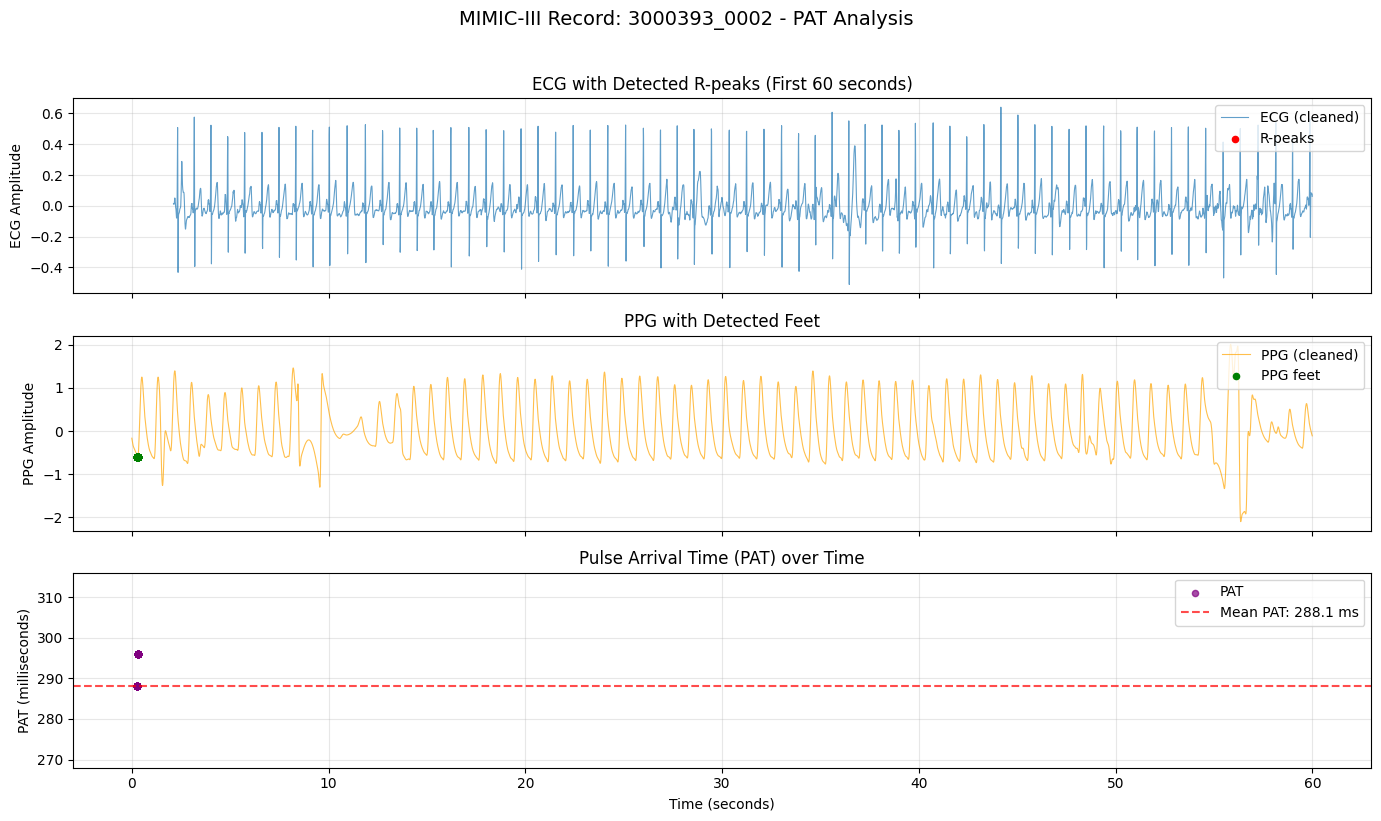

In [27]:
# Plot first 60 seconds
plot_duration = 60  # seconds
plot_samples = min(fs * plot_duration, len(ecg_5min))
plot_times = np.arange(plot_samples) / fs

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# ECG with R-peaks
axes[0].plot(plot_times, ecg_cleaned[:plot_samples], label='ECG (cleaned)', alpha=0.7, linewidth=0.8)
r_in_plot = r_peaks[r_peaks < plot_samples]
axes[0].scatter(r_times[r_times < plot_duration],
                ecg_cleaned[r_in_plot],
                color='red', s=20, label='R-peaks', zorder=5)
axes[0].set_ylabel('ECG Amplitude')
axes[0].legend(loc='upper right')
axes[0].set_title(f'ECG with Detected R-peaks (First {plot_duration} seconds)')
axes[0].grid(True, alpha=0.3)

# PPG with feet
axes[1].plot(plot_times, ppg_cleaned[:plot_samples], label='PPG (cleaned)', color='orange', alpha=0.7, linewidth=0.8)
ppg_feet_in_plot = ppg_feet[ppg_feet < plot_samples]
axes[1].scatter(ppg_feet_times[ppg_feet_times < plot_duration],
                ppg_cleaned[ppg_feet_in_plot],
                color='green', s=20, label='PPG feet', zorder=5)
axes[1].set_ylabel('PPG Amplitude')
axes[1].legend(loc='upper right')
axes[1].set_title('PPG with Detected Feet')
axes[1].grid(True, alpha=0.3)

# PAT values
pat_in_plot = pat[pat_times < plot_duration]
pat_times_in_plot = pat_times[pat_times < plot_duration]
axes[2].scatter(pat_times_in_plot, pat_in_plot * 1000,
                color='purple', s=20, label='PAT', alpha=0.7)
if len(pat_in_plot) > 0:
    axes[2].axhline(y=np.mean(pat)*1000, color='red', linestyle='--',
                    label=f'Mean PAT: {np.mean(pat)*1000:.1f} ms', alpha=0.7)
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('PAT (milliseconds)')
axes[2].legend(loc='upper right')
axes[2].set_title('Pulse Arrival Time (PAT) over Time')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(max(0, np.min(pat)*1000 - 20), np.max(pat)*1000 + 20)

plt.suptitle(f'MIMIC-III Record: {record.record_name} - PAT Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Figure above shows ECG and PPG signals from a MIMIC-III waveform record with detected R-peaks and pulse feet, respectively. R-peaks provide a robust electrical timing reference, while pulse feet mark the arrival of the peripheral pulse wave. Pulse arrival time (PAT) is computed as the temporal difference between these events, yielding physiologically plausible values and forming the basis for subsequent exploration of adaptive NIBP triggering strategies